### Portfolio Testing (pricing)

In [14]:
import pandas as pd
import numpy as np
from environment import Environment
from pandas.tseries.offsets import MonthEnd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from historical import HistoricalData
from pandas._libs.tslibs.timestamps import Timestamp, Timedelta

path = "data\\"
env_df = pd.read_csv(path + "Consolidated.csv", header = [0,1], index_col=[0])
targets_df = pd.read_csv(path + "Targets.csv", index_col=[0])
features_df = pd.read_csv(path + "Features.csv", header = [0,1], index_col=[0])


data = HistoricalData(env_df, features_df, targets_df)

In [16]:
import instrument

date = Timestamp('2018-12-31')


opt_buy = date + MonthEnd(2)
env_now = Environment(*data.get_env_args(date))
pos_dict = {}
etf_dict = {}


icash = instrument.Cash('USD')
for etf in env_df[['EQ', 'FI', 'EM', 'RE']].columns.droplevel():
    etf_dict[etf] = instrument.Equity(etf, 'USD')
    pos_dict[etf_dict[etf]] = 200000/27/env_now.prices[etf]

iput = instrument.Option(name='SPY Put', ccy='USD', is_call=0, ul='SPY US Equity',
                       K=etf_dict['SPY US Equity'].value(env_now)*0.9, T=opt_buy)

icall = instrument.Option(name='SPY Call', ccy='USD', is_call=1, ul='SPY US Equity',
                       K=etf_dict['SPY US Equity'].value(env_now)*1.1, T=opt_buy)




pos_dict[iput] = pos_dict[etf_dict['SPY US Equity']] * 5
pos_dict[icall] = pos_dict[etf_dict['SPY US Equity']] * 5


pos_dict[icash] = -(pos_dict[iput]*iput.value(env_now) + pos_dict[icall]*icall.value(env_now))

In [17]:
# option price
icall.value(env_now)

4.213865086912866

In [18]:
from portfolio import Portfolio
my_pf = Portfolio(pos_dict)
my_pf.calc_value(env_now)

200000.00000000003

### Regression Testing (mapping shocks to assets)

In [19]:
from historical import ShockMap, Distribution
sm = ShockMap(data, date)
dist = Distribution(data, date, method='normal')

In [20]:
rets = []
val_now = my_pf.calc_value(env_now)
for i in range(1000):
    asset_shocks = sm.map_factors(dist.generate_shock())
    env_sim = env_now.simulate(asset_shocks)
    #print(my_pf.calc_value(env_sim))
    #print(i1.value(env_sim), i2.value(env_sim))
    ret = np.log(my_pf.calc_value(env_sim)/val_now)
    rets.append(ret)
    
rets = pd.Series(rets)

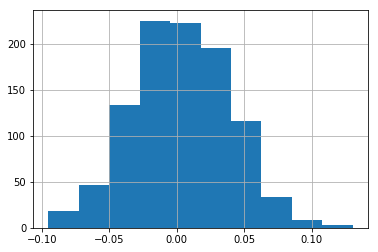

In [21]:
import matplotlib.pyplot as plt
rets.hist(bins=10)
plt.show()

### Testing portfolio performance

In [22]:
pf_val = 200000
date = Timestamp('2014-06-01') + MonthEnd(0)
opt_mat = date + MonthEnd(2)
env_now = Environment(*data.get_env_args(date))
pos_dict = {}
etf_dict = {}

icash = instrument.Cash('USD')
for etf in env_df[['EQ', 'FI', 'EM', 'RE']].columns.droplevel():
    etf_dict[etf] = instrument.Equity(etf, 'USD')
    pos_dict[etf_dict[etf]] = pf_val/27/env_now.prices[etf]

iput = instrument.Option(name='SPY Put', ccy='USD', is_call=0, ul='SPY US Equity',
                       K=etf_dict['SPY US Equity'].value(env_now)*0.9, T=opt_mat)

icall = instrument.Option(name='SPY Call', ccy='USD', is_call=1, ul='SPY US Equity',
                       K=etf_dict['SPY US Equity'].value(env_now)*1.1, T=opt_mat)

pos_dict[iput] = pos_dict[etf_dict['SPY US Equity']] * 5
pos_dict[icall] = pos_dict[etf_dict['SPY US Equity']] * 5
pos_dict[icash] = -(pos_dict[iput]*iput.value(env_now) + pos_dict[icall]*icall.value(env_now))
my_pf = Portfolio(pos_dict)

In [23]:
pf_vals = []
for i in range(1, 60):
    # set date to nex month
    date = Timestamp('2014-06-01') + MonthEnd(i)
    opt_mat = date + MonthEnd(2)
    env_now = Environment(*data.get_env_args(date))
    

    # sell current options
    opt_val = pos_dict[iput] * iput.value(env_now) + pos_dict[icall] * icall.value(env_now)
    my_pf.pf_units[iput] = 0
    my_pf.pf_units[icall] = 0
    del pos_dict[iput], pos_dict[icall]
    
    # add cash from sold options
    my_pf.pf_units[icash] = my_pf.pf_units[icash] + opt_val
    
    # buy new options
    iput = instrument.Option(name='SPY Put', ccy='USD', is_call=0, ul='SPY US Equity',
                           K=etf_dict['SPY US Equity'].value(env_now)*0.9, T=opt_mat)

    icall = instrument.Option(name='SPY Call', ccy='USD', is_call=1, ul='SPY US Equity',
                           K=etf_dict['SPY US Equity'].value(env_now)*1.1, T=opt_mat)
    
    
    pos_dict[iput] = pos_dict[etf_dict['SPY US Equity']] * 5
    pos_dict[icall] = pos_dict[etf_dict['SPY US Equity']] * 5
    pos_dict[icash] = pos_dict[icash] - (pos_dict[iput]*iput.value(env_now) + pos_dict[icall]*icall.value(env_now))
    
    # record portf val
    pf_vals.append(my_pf.calc_value(env_now))

In [24]:
pf_vals = np.array(pf_vals)
pf_rets = pf_vals[1:]/pf_vals[0:-1] - 1

In [25]:
m = pf_rets.mean()*12
s = pf_rets.std()*np.sqrt(12)
print(m,s)
print(m/s)

0.05831585774853454 0.08534665960589881
0.6832822516758932


In [26]:
var = np.percentile(pf_rets, 5)*my_pf.calc_value(env_now)
cvar = pf_rets[pf_rets<=np.percentile(pf_rets, 5)].mean()*my_pf.calc_value(env_now)
print(-var, -cvar)

12024.031844906332 13719.778867905483
